# Convergence Analysis of Ladder Methods for Parallel Transport

This is the companion notebook to the paper on ladder methods for the approximate computation of parallel transport on Riemannian manifolds by N. Guigui and X. Pennec

## Introduction

The scheme consists in building geodesic parallelograms, using the midpoint rule, as one would do in a Euclidean space. This is illustrated below to approximate the parallel transport of the vector $v$ along the geodesic starting from $x$ with initial velocity $w$.

<img src='figures/schild_simple_construction.png' width=300>

However, in the presence of curvature, we showed that $u^w$ is not exactly the parallel transport of $v$, but there is a deviation, wich can be measured at $x$, letting $u$ the (exact) parallel transport of $u^w$ back to $x$ (along the same geodesic). If $w,v$ are small enough we in fact have

$$u = v + \frac{1}{2} R(w,v)v $$

This can then be iterated for any $w$, by choosing an integer $N$ such that $\frac{w}{N}$ is "small enough", to break down the geodesic into $N$ segments where the above construction is valid, this scheme is known as ***Schild's Ladder***.

<img src='figures/schild_iterated_construction.png' width=600>

But of course, on a flat screen, this is not so exciting, let's instead have a look at this scheme on the sphere! We randomly draw a point $x$ and two orthonormal vectors $v,w$ tangent at $x$.

In [2]:
import utils
from geomstats.geometry.hypersphere import Hypersphere

sphere = Hypersphere(2)
x = sphere.random_uniform()

v, w = utils.random_orthonormal_sphere(x)

<IPython.core.display.Javascript object>


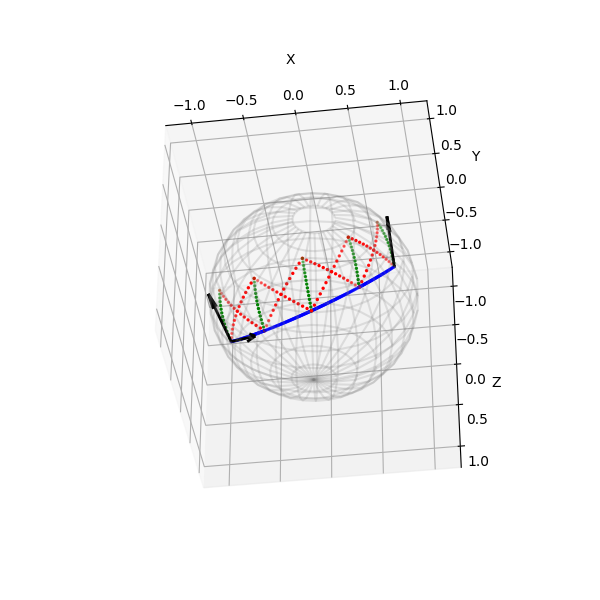

In [3]:
%matplotlib notebook
import matplotlib.pyplot as plt

fig = utils.show_schild(v / 2, w * 2, x)
fig.show()

## Convergence on the Sphere

Now from the above formula for $u$, we understand that the error term will add up as we iterate the construction. So in order to ensure that this term goes to $0$ as $N$ goes to infinity, we also scale $v$ by a a factor $\frac{1}{N^\alpha}$. We then showed in theorem 2 of the paper that the algorithm the converges with a speed of convergence $\alpha$ , i.e. the overall error decreases proportionally to $\frac{1}{N^\alpha}$. This is exactly what we observe on the sphere below.

The exact parallel transport is known and computed in closed-form, to serve as ground truth:

In [12]:
exact_transport = sphere.metric.parallel_transport(v, w, x)
exact_transport_w = sphere.metric.parallel_transport(w, w, x)

In [13]:
from numpy import logspace

n_numbers = 20
n_range = [int(k) for k in logspace(1, 2.5, n_numbers)]

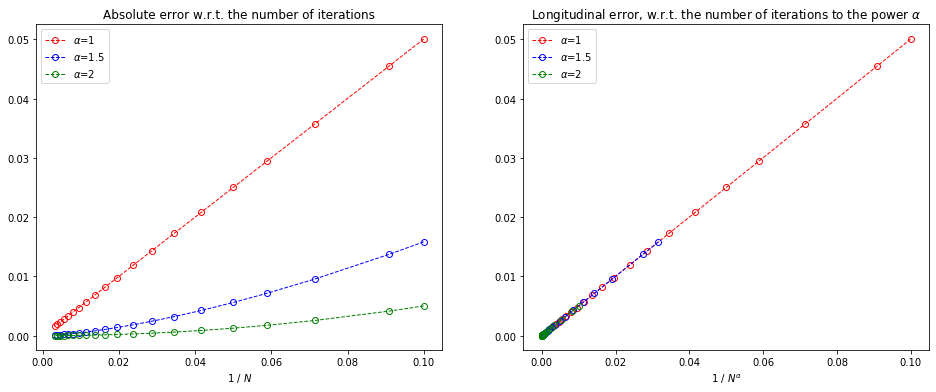

In [15]:
%matplotlib inline
import geomstats.backend as gs

plt.figure(figsize=(16, 6));
ax_abs = plt.subplot(121)
ax_long = plt.subplot(122)

for alpha, col in zip([1, 1.5, 2], ['r', 'b', 'g']):
    abs_error = []
    longitudinal_error = []

    for n_rungs in n_range:

        ladder = sphere.metric.ladder_parallel_transport(
            v / n_rungs ** alpha, w, x,
            n_rungs=n_rungs, scheme='schild')
        transported = ladder['transported_tangent_vec'] * n_rungs ** alpha
        
        abs_error.append(gs.linalg.norm(transported - exact_transport))
        longitudinal_error.append(
            sphere.metric.inner_product(transported - exact_transport, exact_transport_w))
    
    utils.make_plot(ax_abs, abs_error, [1 / k for k in n_range], col=col, label=rf'$\alpha$={alpha}',
                    title='Absolute error w.r.t. the number of iterations', xlabel = r'1 / $N$')
    utils.make_plot(
        ax_long, longitudinal_error, [1 / k ** alpha for k in n_range], col=col, label=rf'$\alpha$={alpha}',
        xlabel = r'1 / $N^\alpha$', title=r'Longitudinal error, w.r.t. the number of iterations to the power $\alpha$')
plt.show()

## Convergence on the manifold of SPD matrices

In [ ]:
from geomstats.geometry.spd_matrices import SPDMatrices, SPDMetricAffine

spd = SPDMatrices(3)
metric = SPDMetricAffine(3)
point = spd.random_uniform()

tan_a, tan_b = utils.random_orthonormal_spd(point)

exact_transport = metric.parallel_transport(tan_a, tan_b, point)
exact_transport_tan_b = metric.parallel_transport(tan_b, tan_b, point)
end_point = metric.exp(tan_b, point)

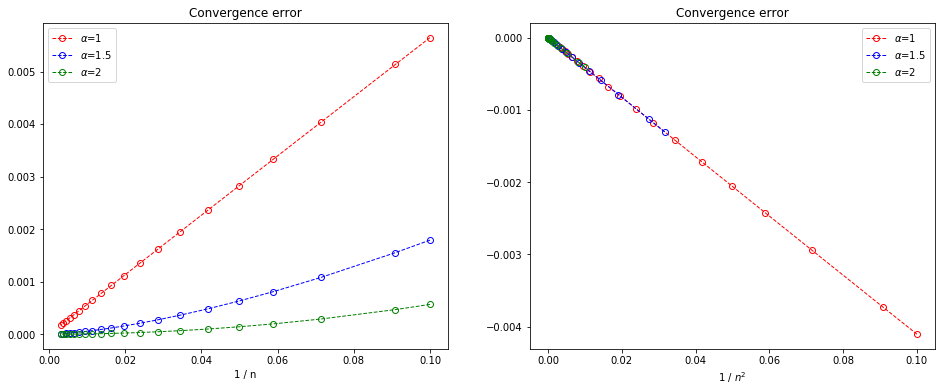

In [6]:
plt.figure(figsize=(16, 6));
ax_abs = plt.subplot(121)
ax_long = plt.subplot(122)
for alpha, col in zip([1, 1.5, 2], ['r', 'b', 'g']):
    abs_error = []
    longitudinal_error = []
    
    for n_rungs in n_range:

        ladder = metric.ladder_parallel_transport(
            tan_a / n_rungs ** alpha,
            tan_b,
            point,
            n_rungs=n_rungs,
            scheme='schild')
        transported = ladder['transported_tangent_vec'] * n_rungs ** alpha
        
        abs_error.append(metric.norm(transported - exact_transport, point))
        longitudinal_error.append(
            metric.inner_product(transported - exact_transport, exact_transport_tan_b,
                                 end_point))
    
    utils.make_plot(ax_abs, abs_error, [1 / k for k in n_range], col=col, label=rf'$\alpha$={alpha}')
    utils.make_plot(
        ax_long, longitudinal_error, [1 / k ** alpha for k in n_range], col=col, label=rf'$\alpha$={alpha}',
        xlabel = r'1 / $n^2$')
plt.show()

## Infinitesimal scheme on SE(3)

In [18]:
from sen_tools.sen import SenTools
from geomstats.geometry.special_euclidean import SpecialEuclidean

tools = SenTools(3)
space = SpecialEuclidean(3)

gs.random.seed(0)
point = space.random_uniform()

n_numbers = 10
n_range = [int(k) for k in logspace(1, 2, n_numbers)]

### Verification of lemma 1

By default $\beta=1$, i.e, the metric is isotropic and we can verify that the covariant derivative of the curvature is identically zero:

In [25]:
tools.set_anisotropic_metric(1)
is_symmetric = True
for x in tools.basis:
    for i, y in enumerate(tools.basis[:-1]):
        for z in tools.basis[i+1:]:
            for t in tools.basis:
                if not gs.isclose(tools.nabla_curvature(x, y, z, t), 0).all():
                    is_symmetric = False
print(is_symmetric)

True


On the other hand, we can set any $\beta \neq 1$, here e.g. $\beta=2$ and verify that there exists vectors $x,y,z,t$ in the Lie algebra for which $\nabla_x R(y,z)t \neq 0 $:

In [27]:
tools.set_anisotropic_metric(2)
is_symmetric = True
for x in tools.basis:
    for i, y in enumerate(tools.basis[:-1]):
        for z in tools.basis[i + 1:]:
            for t in tools.basis:
                if not gs.isclose(tools.nabla_curvature(x, y, z, t), 0).all():
                    is_symmetric = False
print(is_symmetric)

False


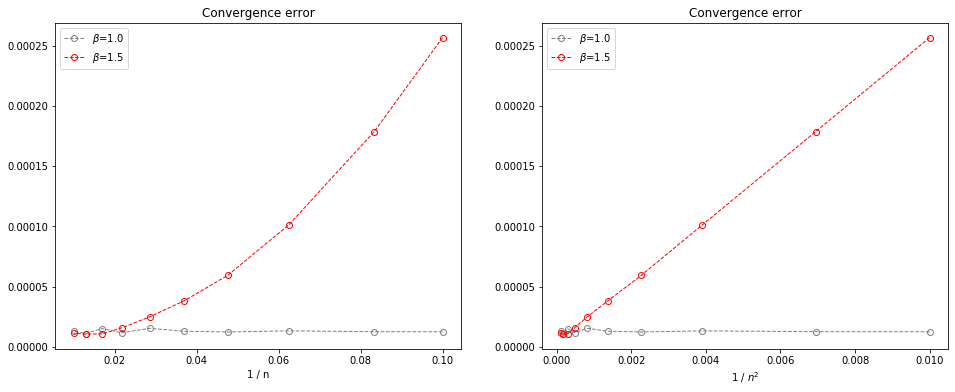

In [8]:
plt.figure(figsize=(16, 6));
ax_abs = plt.subplot(121)
ax_straight = plt.subplot(122)
for beta, col in zip([1., 1.5],  ['gray', 'r', 'b', 'g']):
    tools.set_anisotropic_metric(beta)
    
    # take orthonormal basis vectors that don't change when changing the metric
    tan_a = tools.basis[0]
    tan_b = tools.basis[4]
    tan_b = space.compose(point, tan_b)
    tan_a = space.compose(point, tan_a)

    # exact parallel transport
    exact_transport, end_point = tools.parallel_transport(tan_a, tan_b, point)
    exact_transport_tan_b = tools.log(tools.exp(2 * tan_b, point, n_steps=20), end_point, tol=1e-14, n_steps=20)

    abs_error = []
    longitudinal_error = []
    for n_rungs in n_range:
        ladder, end_point = tools.pole_ladder(
            tan_a / n_rungs, tan_b, point, n_rungs=n_rungs, step='rk4', n_steps=1, tol=1e-14)
        transported = ladder * n_rungs
        abs_error.append(tools.norm(transported - exact_transport, end_point))

    utils.make_plot(ax_abs, abs_error, [1 / k for k in n_range], col=col, label=rf'$\beta$={beta}')
    utils.make_plot(
        ax_straight, abs_error, [1 / k ** 2 for k in n_range], col=col, label=rf'$\beta$={beta}',
        xlabel = r'1 / $n^2$')
plt.show()